# Robomed

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
from tqdm import tqdm_notebook
from txt_feat import get_features
from sklearn.cluster import KMeans
from utils import get_disease_class
from lstm import KTokenizer, get_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

/home/s_belyaev/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Args

In [2]:
TRAIN_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/train_data.csv'
TRAINF_PATH = 'pos_neg.csv'
TEST_PATH = '~/.kaggle/competitions/ai-hack-2018-spb-robomed/test_data.csv'
TESTF_PATH = 'test_pos_neg.csv'
SUBMISSION_PATH = 'submission.csv'
MODEL_SAVE_PATH = 'model.pkl'

## Read

In [3]:
def initial_pre(df):
    df = df.copy()
    del df['ID']
    rename_map = {
        'Код_диагноза': 'diag_code',
        'Диагноз': 'diag',
        'Возраст': 'age',
        'Пол': 'sex',
        'Общее состояние': 'state',
        'аллергия': 'allergies',
        'Анамнез заболевания': 'anamnesis',
        'Внешний осмотр': 'checkup',
        'Revisit': 'revisit'
    }
    return df.rename(columns=rename_map)

In [4]:
pd.read_csv(TRAIN_PATH).head()

,ID,Код_диагноза,Диагноз,Возраст,Пол,Общее состояние,аллергия,Анамнез заболевания,Внешний осмотр,Revisit
0,0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1
1,1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1
2,2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1
3,3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1
4,4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1


In [5]:
df = initial_pre(pd.concat([pd.read_csv(TRAIN_PATH), pd.read_csv(TRAINF_PATH, index_col=0)], axis=1))
len(df)

283086

In [6]:
df.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit,pos,neg,pos_w,neg_w
0,J06.0,Острый ларингофарингит,29,2,NaN,NaN,NaN,На жевательной поверхности 2.6- кариозная поло...,1,0.0,0.0,0.0,0.0
1,N76.1,Подострый и хронический вагинит,45,2,NaN,NaN,считает себя больной на протяжении многих лет....,NaN,1,0.0,0.0,0.0,0.0
2,L23.9,"Аллергический контактный дерматит, причина не ...",63,2,NaN,NaN,"Болен около 2-х дней, когда появились описанны...",NaN,1,0.0,0.0,0.0,0.0
3,N48.1,Баланопостит,43,2,NaN,не отягощен,NaN,NaN,1,0.0,0.0,0.0,0.0
4,Z00.0,Общий медицинский осмотр,29,1,NaN,NaN,провела полное обследование для оперативного л...,NaN,1,0.0,0.0,0.0,0.0


In [7]:
df.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,revisit,pos,neg,pos_w,neg_w
count,283086,283086,283086.000000,283086.000000,41696,40908,203656,13295,283086.000000,283086.000000,283086.000000,283086.000000,283086.000000
unique,3437,3394,NaN,NaN,2942,5141,152589,779,NaN,NaN,NaN,NaN,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN,NaN,NaN,NaN,NaN
freq,11214,11214,NaN,NaN,8960,17361,3025,6622,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,41.696905,1.708347,NaN,NaN,NaN,NaN,0.828639,0.143695,0.011767,0.049013,-0.004810
std,NaN,NaN,21.540704,0.454524,NaN,NaN,NaN,NaN,0.376825,0.393101,0.109234,0.135304,0.044713
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.869863
25%,NaN,NaN,31.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,38.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df.dtypes

diag_code     object
diag          object
age            int64
sex            int64
state         object
allergies     object
anamnesis     object
checkup       object
revisit        int64
pos          float64
neg          float64
pos_w        float64
neg_w        float64
dtype: object

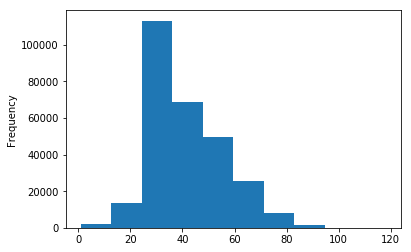

In [9]:
age = df.age.copy()
age[age > 120] = None
age.plot('hist');

## Test analysis

### Look up

In [10]:
tdf = initial_pre(pd.concat([pd.read_csv(TEST_PATH), pd.read_csv(TESTF_PATH, index_col=0)], axis=1))
tdf.head()

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,pos,neg,pos_w,neg_w
0,Z39.2,Рутинное послеродовое наблюдение,41,2,Общее самочувствие удовлетворительное. Кожные ...,Аллергию на лекарства - отрицает.,NaN,NaN,0.0,0.0,0.0,0.0
1,M54.2,Цервикалгия,64,2,NaN,не отягощен,NaN,NaN,0.0,0.0,0.0,0.0
2,M41,Сколиоз,34,2,"Удовлетворительное. Температура тела - 36,6. С...",NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,J31.2,Хронический фарингит,58,2,NaN,NaN,NaN,Общее состояние удовлетворительное. Конфигурац...,0.0,0.0,0.0,0.0
4,M21.4,Плоская стопа [pes planus] (приобретенная),34,2,NaN,NaN,Жалобы сегодня с утра,NaN,0.0,0.0,0.0,0.0


In [11]:
tdf.describe(include='all')

,diag_code,diag,age,sex,state,allergies,anamnesis,checkup,pos,neg,pos_w,neg_w
count,100000,100000,100000.000000,100000.000000,27475,36484,39282,10710,100000.000000,100000.000000,100000.000000,100000.000000
unique,2750,2718,NaN,NaN,2337,4790,31786,744,NaN,NaN,NaN,NaN
top,N77.1*,"Вагинит, вульвит и вульвовагинит при инфекцион...",NaN,NaN,Общее самочувствие удовлетворительное. Кожные ...,не отягощен,консультация по проведенному обследованию и ко...,удовлетворительное.,NaN,NaN,NaN,NaN
freq,4618,4618,NaN,NaN,5807,15593,540,5382,NaN,NaN,NaN,NaN
mean,NaN,NaN,42.581630,1.663910,NaN,NaN,NaN,NaN,0.083690,0.007140,0.026702,-0.002649
std,NaN,NaN,32.847483,0.472372,NaN,NaN,NaN,NaN,0.304182,0.084906,0.097972,0.031554
min,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,-0.801064
25%,NaN,NaN,32.000000,1.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,39.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,51.000000,2.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000


In [12]:
df.sex.value_counts()

2    200523
1     82563
Name: sex, dtype: int64

In [13]:
tdf.sex.value_counts()

2    66391
1    33609
Name: sex, dtype: int64

### Not in `tdf`

In [14]:
def filter_not_in_test(df, tdf, column):
    df = df.copy()
    in_tdf = set(tdf.loc[:, column])
    return df[df.loc[:, column].isin(in_tdf)].copy()

In [15]:
for column in tqdm_notebook(df.columns):
    if column not in {'revisit', 'anamnesis'}:
        df = filter_not_in_test(df, tdf, column)
        print('after', column, df.shape)
df.shape

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

after diag_code (280470, 13)
after diag (280470, 13)
after age (280456, 13)
after sex (280456, 13)
after state (278242, 13)
after allergies (274857, 13)
after checkup (274572, 13)
after pos (274572, 13)
after neg (274572, 13)
after pos_w (238145, 13)
after neg_w (235532, 13)



(235532, 13)

### Strings fuzzy matching

In [16]:
def group_column(df, tdf, column):
    df, tdf = df.copy(), tdf.copy()
    columnv = pd.concat([df[column], tdf[column]])
    cvc = columnv.value_counts()
    bins = []
    for s, c in tqdm_notebook(cvc.iteritems()):
        max_id, max_score = None, None
        for id_, bin_ in enumerate(bins):
            cur_score = fuzz.ratio(s, bin_[0])
            if max_score is None or cur_score > max_score:
                max_id = id_
                max_score = cur_score
        if max_id is not None and max_score > 75:
            bins[max_id].append(s)
        else:
            bins.append([s])
    remap_dict = {}
    for bin_ in bins:
        base = bin_[0]
        for v in bin_:
            remap_dict[v] = base
    df[column] = df[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    tdf[column] = tdf[column].apply(lambda x: remap_dict[x] if x in remap_dict else x)
    return df, tdf

In [17]:
SIMILAR_TEXT_COLUMNS = ['state', 'allergies', 'checkup']
for column in tqdm_notebook(SIMILAR_TEXT_COLUMNS):
    df, tdf = group_column(df, tdf, column)
df.shape, tdf.shape

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

((235532, 13), (100000, 12))

## Preprocess

In [18]:
def parse_diag_code(diag_code, 
                    dc_pattern=re.compile('([A-Z])?([0-9][0-9])?(\.([0-9]))?')):
    m = dc_pattern.match(diag_code)
    letter, code, subcode = m.group(1), m.group(2), m.group(4)
    code = int(code) if code is not None else None
    subcode = int(subcode) if subcode is not None else None
    return letter, code, subcode

In [19]:
class FFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._encs = None
    
    def fit(self, df):
        return self
    
    def transform(self, df, tdf=None):
        df = df.copy()
    
        features = []
        
        # `diag_code`
        def to_str(x):
            if x is None:
                return ''
            else:
                return str(x)
        
        def pparse(x):
            l, c, s = x
            c = to_str(l) + to_str(c)
            if not c:
                c = None
            return (l, c)
        
        parts = list(df.diag_code \
                     .apply(parse_diag_code) \
                     .apply(pparse))
        features.append(pd.DataFrame(parts, 
                                     columns=['letter', 'code', 'subcode'][:2],
                                     dtype=object, index=df.index))

        # `age`
        df.age = df.age.astype(float)
        df.loc[df.age > 120, 'age'] = np.nan
#         df.age = df.age.astype(str)  # => To cat
        features.append(df[['age']])

        # `sex`
        features.append(df[['sex']])

        # `state`
        def state_map(s):
            if 'удовлетворительн' in str(s).lower():
                return True
            else:
                return False
            
        features.append(pd.DataFrame(df.state.apply(state_map).astype(int),
                                     columns=['state'],
                                     index=df.index, dtype=int))
        
        # `diag`, `allergies`, `checkup`
        features.append(df[['allergies', 'checkup']])
        
        
        # anamnesis
        features.append(get_features(df.anamnesis, df.index))
        features.append(pd.DataFrame(df.anamnesis.isnull().as_matrix().astype(int), 
                                     columns=['anamnesis_null'],
                                     index=df.index))
        
        # sentiment features
        features.append(df[['pos', 'neg', 'pos_w', 'neg_w']])

        data = pd.concat(features, axis=1)
        
        # object => int
#         data = data.apply(lambda c: c.fillna('NaN') if (c.dtype == object) else c)
        objs = data.dtypes[data.dtypes == object].index.tolist()
        if self._encs is None:
            self._encs = [LabelEncoder().fit(pd.concat([data[obj].fillna('NaN'), 
                                                        pd.Series('NaN')], axis=0)) for obj in objs]
        for obj, enc in zip(objs, self._encs):
            data.loc[~data[obj].isin(enc.classes_), obj] = np.nan
            data[obj] = enc.transform(data[obj].fillna('NaN'))
        
        if 'revisit' in df:
            data = (data, df.revisit)

        return data

In [20]:
ff = FFTransformer()
X, y = ff.fit_transform(df)
X.head()

,letter,code,age,sex,state,allergies,checkup,count_nums,exclamation,larger_than_three,not_stop_words,number_words,punct,stop_words,string_len,anamnesis_null,pos,neg,pos_w,neg_w
0,9,315,29.0,2,0,82,94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,13,532,45.0,2,0,82,59,0.0,0.0,30.0,30.0,42.0,4.0,12.0,302.0,0,0.0,0.0,0.0,0.0
2,11,374,63.0,2,0,82,59,1.0,0.0,10.0,11.0,14.0,5.0,3.0,99.0,0,0.0,0.0,0.0,0.0
3,13,517,43.0,2,0,1100,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,23,716,29.0,1,0,82,59,0.0,0.0,5.0,5.0,6.0,0.0,1.0,52.0,0,0.0,0.0,0.0,0.0


In [21]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [22]:
y.dtype

dtype('int64')

## TT split

In [23]:
def downsampling(X, y):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    sampled_ids1 = y[y == 1].sample(len(ids0)).index
    nX = pd.concat([X.loc[ids0], X.loc[sampled_ids1]], axis=0)
    ny = pd.concat([y[ids0], y[sampled_ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny


def upsampling(X, y, max_cnt=10000):
    ids0, ids1 = y[y == 0].index, y[y == 1].index
    n = min(len(ids1), max_cnt)
    sampled_ids0 = y[y == 0].sample(n, replace=True).index
    index = np.arange(y.index.max() + 1, y.index.max() + n + 1)
    nX = X.loc[sampled_ids0]
    nX.index = index
    nX = pd.concat([nX, X.loc[ids1]], axis=0)
    ny = pd.concat([pd.Series(y[sampled_ids0].as_matrix(), index=index), y[ids1]], axis=0)
    assert (nX.index == ny.index).all()
    return nX, ny

In [24]:
preprocess = FFTransformer()
X, y = preprocess.fit_transform(df)
cat_features = np.where(X.dtypes != np.float)[0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
# X_train, y_train = upsampling(X_train, y_train)
X_test = preprocess.transform(tdf)
X_train.shape, X_val.shape, X_test.shape

((223755, 20), (11777, 20), (100000, 20))

## CatBoost

https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/

### Run

In [25]:
N_MODELS = 5

In [26]:
models = [cb.CatBoostClassifier(depth=8, eval_metric='AUC', random_seed=42,
                                iterations=2000, od_type='Iter', od_wait=300) 
          for _ in range(N_MODELS)]

In [27]:
def get_stack_score(X):
    return np.vstack((model.predict_proba(X)[:, 1] for model in models)).mean(axis=0)


def get_f_im():
    return np.vstack((model.feature_importances_ for model in models)).mean(axis=0)

In [28]:
X.dtypes

letter                 int64
code                   int64
age                  float64
sex                    int64
state                  int64
allergies              int64
checkup                int64
count_nums           float64
exclamation          float64
larger_than_three    float64
not_stop_words       float64
number_words         float64
punct                float64
stop_words           float64
string_len           float64
anamnesis_null         int64
pos                  float64
neg                  float64
pos_w                float64
neg_w                float64
dtype: object

In [29]:
for i, model in enumerate(models):
    print(f'ITERATION NUMBER {i}')
    X_train, X_val, y_train, y_val = train_test_split(*downsampling(X, y), test_size=0.1)
    model.fit(X_train, y_train, cat_features=cat_features, 
              use_best_model=True, eval_set=(X_val, y_val), 
              plot=False);

ITERATION NUMBER 0
0:	learn: 0.7015314	test: 0.6953023	best: 0.6953023 (0)	total: 223ms	remaining: 7m 26s
1:	learn: 0.7018400	test: 0.6956926	best: 0.6956926 (1)	total: 414ms	remaining: 6m 53s
2:	learn: 0.7018609	test: 0.6955200	best: 0.6956926 (1)	total: 558ms	remaining: 6m 11s
3:	learn: 0.7027189	test: 0.6966827	best: 0.6966827 (3)	total: 680ms	remaining: 5m 39s
4:	learn: 0.7026131	test: 0.6966195	best: 0.6966827 (3)	total: 774ms	remaining: 5m 8s
5:	learn: 0.7030901	test: 0.6970059	best: 0.6970059 (5)	total: 868ms	remaining: 4m 48s
6:	learn: 0.7032785	test: 0.6971208	best: 0.6971208 (6)	total: 969ms	remaining: 4m 35s
7:	learn: 0.7033018	test: 0.6971002	best: 0.6971208 (6)	total: 1.08s	remaining: 4m 30s
8:	learn: 0.7035900	test: 0.6971669	best: 0.6971669 (8)	total: 1.22s	remaining: 4m 30s
9:	learn: 0.7039767	test: 0.6976766	best: 0.6976766 (9)	total: 1.36s	remaining: 4m 30s
10:	learn: 0.7041487	test: 0.6976488	best: 0.6976766 (9)	total: 1.51s	remaining: 4m 33s
11:	learn: 0.7042678	tes

94:	learn: 0.7218125	test: 0.7112106	best: 0.7112106 (94)	total: 12.3s	remaining: 4m 7s
95:	learn: 0.7219440	test: 0.7112867	best: 0.7112867 (95)	total: 12.5s	remaining: 4m 7s
96:	learn: 0.7220581	test: 0.7113518	best: 0.7113518 (96)	total: 12.6s	remaining: 4m 8s
97:	learn: 0.7221532	test: 0.7114349	best: 0.7114349 (97)	total: 12.7s	remaining: 4m 7s
98:	learn: 0.7223189	test: 0.7115272	best: 0.7115272 (98)	total: 12.8s	remaining: 4m 6s
99:	learn: 0.7224207	test: 0.7114647	best: 0.7115272 (98)	total: 13s	remaining: 4m 6s
100:	learn: 0.7224533	test: 0.7114758	best: 0.7115272 (98)	total: 13.1s	remaining: 4m 6s
101:	learn: 0.7225268	test: 0.7115318	best: 0.7115318 (101)	total: 13.2s	remaining: 4m 6s
102:	learn: 0.7226617	test: 0.7115900	best: 0.7115900 (102)	total: 13.4s	remaining: 4m 6s
103:	learn: 0.7229035	test: 0.7115690	best: 0.7115900 (102)	total: 13.6s	remaining: 4m 7s
104:	learn: 0.7229652	test: 0.7116085	best: 0.7116085 (104)	total: 13.7s	remaining: 4m 7s
105:	learn: 0.7230018	tes

187:	learn: 0.7313649	test: 0.7128362	best: 0.7129945 (154)	total: 25s	remaining: 4m 1s
188:	learn: 0.7314366	test: 0.7128873	best: 0.7129945 (154)	total: 25.1s	remaining: 4m
189:	learn: 0.7314878	test: 0.7128837	best: 0.7129945 (154)	total: 25.3s	remaining: 4m
190:	learn: 0.7315128	test: 0.7128964	best: 0.7129945 (154)	total: 25.4s	remaining: 4m
191:	learn: 0.7315776	test: 0.7129110	best: 0.7129945 (154)	total: 25.6s	remaining: 4m 1s
192:	learn: 0.7316138	test: 0.7129096	best: 0.7129945 (154)	total: 25.8s	remaining: 4m 1s
193:	learn: 0.7317700	test: 0.7129175	best: 0.7129945 (154)	total: 25.9s	remaining: 4m 1s
194:	learn: 0.7319484	test: 0.7129279	best: 0.7129945 (154)	total: 26s	remaining: 4m
195:	learn: 0.7320570	test: 0.7129712	best: 0.7129945 (154)	total: 26.1s	remaining: 4m
196:	learn: 0.7321299	test: 0.7129733	best: 0.7129945 (154)	total: 26.2s	remaining: 4m
197:	learn: 0.7322239	test: 0.7129972	best: 0.7129972 (197)	total: 26.4s	remaining: 4m
198:	learn: 0.7322821	test: 0.71300

279:	learn: 0.7392864	test: 0.7136996	best: 0.7136996 (279)	total: 37.4s	remaining: 3m 49s
280:	learn: 0.7393934	test: 0.7136748	best: 0.7136996 (279)	total: 37.6s	remaining: 3m 49s
281:	learn: 0.7394224	test: 0.7136972	best: 0.7136996 (279)	total: 37.7s	remaining: 3m 49s
282:	learn: 0.7394819	test: 0.7137041	best: 0.7137041 (282)	total: 37.8s	remaining: 3m 49s
283:	learn: 0.7395434	test: 0.7136948	best: 0.7137041 (282)	total: 38s	remaining: 3m 49s
284:	learn: 0.7396214	test: 0.7136927	best: 0.7137041 (282)	total: 38.1s	remaining: 3m 49s
285:	learn: 0.7398186	test: 0.7136575	best: 0.7137041 (282)	total: 38.2s	remaining: 3m 48s
286:	learn: 0.7398574	test: 0.7136699	best: 0.7137041 (282)	total: 38.3s	remaining: 3m 48s
287:	learn: 0.7399615	test: 0.7136736	best: 0.7137041 (282)	total: 38.5s	remaining: 3m 48s
288:	learn: 0.7399935	test: 0.7136781	best: 0.7137041 (282)	total: 38.6s	remaining: 3m 48s
289:	learn: 0.7400579	test: 0.7137004	best: 0.7137041 (282)	total: 38.8s	remaining: 3m 48s
2

371:	learn: 0.7462314	test: 0.7139551	best: 0.7139996 (339)	total: 49.7s	remaining: 3m 37s
372:	learn: 0.7462873	test: 0.7139367	best: 0.7139996 (339)	total: 49.8s	remaining: 3m 37s
373:	learn: 0.7464163	test: 0.7139806	best: 0.7139996 (339)	total: 49.9s	remaining: 3m 37s
374:	learn: 0.7464472	test: 0.7139954	best: 0.7139996 (339)	total: 50.1s	remaining: 3m 36s
375:	learn: 0.7465163	test: 0.7140123	best: 0.7140123 (375)	total: 50.2s	remaining: 3m 36s
376:	learn: 0.7466168	test: 0.7140529	best: 0.7140529 (376)	total: 50.3s	remaining: 3m 36s
377:	learn: 0.7466547	test: 0.7140569	best: 0.7140569 (377)	total: 50.5s	remaining: 3m 36s
378:	learn: 0.7467263	test: 0.7140957	best: 0.7140957 (378)	total: 50.6s	remaining: 3m 36s
379:	learn: 0.7468135	test: 0.7140796	best: 0.7140957 (378)	total: 50.8s	remaining: 3m 36s
380:	learn: 0.7468810	test: 0.7141155	best: 0.7141155 (380)	total: 50.9s	remaining: 3m 36s
381:	learn: 0.7469617	test: 0.7140993	best: 0.7141155 (380)	total: 51s	remaining: 3m 35s
3

462:	learn: 0.7531494	test: 0.7144025	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 26s
463:	learn: 0.7532148	test: 0.7143742	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 26s
464:	learn: 0.7532851	test: 0.7143481	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 26s
465:	learn: 0.7534806	test: 0.7143552	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 25s
466:	learn: 0.7535029	test: 0.7143484	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 25s
467:	learn: 0.7535703	test: 0.7143456	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 25s
468:	learn: 0.7535775	test: 0.7143398	best: 0.7144025 (462)	total: 1m 2s	remaining: 3m 25s
469:	learn: 0.7536622	test: 0.7143555	best: 0.7144025 (462)	total: 1m 3s	remaining: 3m 25s
470:	learn: 0.7537329	test: 0.7144039	best: 0.7144039 (470)	total: 1m 3s	remaining: 3m 25s
471:	learn: 0.7537808	test: 0.7144007	best: 0.7144039 (470)	total: 1m 3s	remaining: 3m 25s
472:	learn: 0.7538050	test: 0.7143937	best: 0.7144039 (470)	total: 1m 3s	remaining: 3m 25s

553:	learn: 0.7595703	test: 0.7145539	best: 0.7146995 (517)	total: 1m 14s	remaining: 3m 14s
554:	learn: 0.7596827	test: 0.7145087	best: 0.7146995 (517)	total: 1m 14s	remaining: 3m 13s
555:	learn: 0.7597325	test: 0.7145290	best: 0.7146995 (517)	total: 1m 14s	remaining: 3m 13s
556:	learn: 0.7598118	test: 0.7145853	best: 0.7146995 (517)	total: 1m 14s	remaining: 3m 13s
557:	learn: 0.7598903	test: 0.7145665	best: 0.7146995 (517)	total: 1m 14s	remaining: 3m 13s
558:	learn: 0.7599370	test: 0.7145685	best: 0.7146995 (517)	total: 1m 15s	remaining: 3m 13s
559:	learn: 0.7600705	test: 0.7146188	best: 0.7146995 (517)	total: 1m 15s	remaining: 3m 13s
560:	learn: 0.7601602	test: 0.7145933	best: 0.7146995 (517)	total: 1m 15s	remaining: 3m 13s
561:	learn: 0.7601786	test: 0.7145759	best: 0.7146995 (517)	total: 1m 15s	remaining: 3m 13s
562:	learn: 0.7602239	test: 0.7146190	best: 0.7146995 (517)	total: 1m 15s	remaining: 3m 12s
563:	learn: 0.7602862	test: 0.7146195	best: 0.7146995 (517)	total: 1m 15s	remain

643:	learn: 0.7662513	test: 0.7147246	best: 0.7148794 (611)	total: 1m 26s	remaining: 3m 2s
644:	learn: 0.7662889	test: 0.7147406	best: 0.7148794 (611)	total: 1m 26s	remaining: 3m 2s
645:	learn: 0.7663255	test: 0.7147540	best: 0.7148794 (611)	total: 1m 26s	remaining: 3m 2s
646:	learn: 0.7664019	test: 0.7147829	best: 0.7148794 (611)	total: 1m 27s	remaining: 3m 2s
647:	learn: 0.7664491	test: 0.7147791	best: 0.7148794 (611)	total: 1m 27s	remaining: 3m 1s
648:	learn: 0.7665851	test: 0.7148770	best: 0.7148794 (611)	total: 1m 27s	remaining: 3m 1s
649:	learn: 0.7665960	test: 0.7148956	best: 0.7148956 (649)	total: 1m 27s	remaining: 3m 1s
650:	learn: 0.7666724	test: 0.7148932	best: 0.7148956 (649)	total: 1m 27s	remaining: 3m 1s
651:	learn: 0.7667485	test: 0.7149010	best: 0.7149010 (651)	total: 1m 27s	remaining: 3m 1s
652:	learn: 0.7668320	test: 0.7148797	best: 0.7149010 (651)	total: 1m 27s	remaining: 3m 1s
653:	learn: 0.7669202	test: 0.7148979	best: 0.7149010 (651)	total: 1m 28s	remaining: 3m 1s

733:	learn: 0.7723807	test: 0.7145822	best: 0.7150832 (679)	total: 1m 38s	remaining: 2m 50s
734:	learn: 0.7724483	test: 0.7146138	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 50s
735:	learn: 0.7725561	test: 0.7145851	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 50s
736:	learn: 0.7726750	test: 0.7145784	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 50s
737:	learn: 0.7727127	test: 0.7145701	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 49s
738:	learn: 0.7728192	test: 0.7145392	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 49s
739:	learn: 0.7728657	test: 0.7145333	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 49s
740:	learn: 0.7728967	test: 0.7145457	best: 0.7150832 (679)	total: 1m 39s	remaining: 2m 49s
741:	learn: 0.7729787	test: 0.7145583	best: 0.7150832 (679)	total: 1m 40s	remaining: 2m 49s
742:	learn: 0.7730240	test: 0.7145784	best: 0.7150832 (679)	total: 1m 40s	remaining: 2m 49s
743:	learn: 0.7730668	test: 0.7145553	best: 0.7150832 (679)	total: 1m 40s	remain

824:	learn: 0.7781578	test: 0.7148231	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 38s
825:	learn: 0.7782608	test: 0.7148270	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 38s
826:	learn: 0.7783139	test: 0.7148425	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 38s
827:	learn: 0.7783846	test: 0.7148595	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 38s
828:	learn: 0.7784536	test: 0.7148199	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 38s
829:	learn: 0.7785285	test: 0.7148584	best: 0.7150832 (679)	total: 1m 51s	remaining: 2m 37s
830:	learn: 0.7785578	test: 0.7148628	best: 0.7150832 (679)	total: 1m 52s	remaining: 2m 37s
831:	learn: 0.7785935	test: 0.7148643	best: 0.7150832 (679)	total: 1m 52s	remaining: 2m 37s
832:	learn: 0.7786671	test: 0.7148628	best: 0.7150832 (679)	total: 1m 52s	remaining: 2m 37s
833:	learn: 0.7787000	test: 0.7148486	best: 0.7150832 (679)	total: 1m 52s	remaining: 2m 37s
834:	learn: 0.7787354	test: 0.7148442	best: 0.7150832 (679)	total: 1m 52s	remain

914:	learn: 0.7838461	test: 0.7148830	best: 0.7150832 (679)	total: 2m 3s	remaining: 2m 26s
915:	learn: 0.7839040	test: 0.7148814	best: 0.7150832 (679)	total: 2m 3s	remaining: 2m 26s
916:	learn: 0.7839826	test: 0.7149032	best: 0.7150832 (679)	total: 2m 3s	remaining: 2m 26s
917:	learn: 0.7840202	test: 0.7148925	best: 0.7150832 (679)	total: 2m 3s	remaining: 2m 26s
918:	learn: 0.7840776	test: 0.7148800	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
919:	learn: 0.7840883	test: 0.7148723	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
920:	learn: 0.7841399	test: 0.7148573	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
921:	learn: 0.7842685	test: 0.7148341	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
922:	learn: 0.7843487	test: 0.7148178	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
923:	learn: 0.7844323	test: 0.7147882	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s
924:	learn: 0.7845188	test: 0.7147899	best: 0.7150832 (679)	total: 2m 4s	remaining: 2m 25s

23:	learn: 0.7106028	test: 0.7078931	best: 0.7078931 (23)	total: 3.09s	remaining: 4m 14s
24:	learn: 0.7113986	test: 0.7086551	best: 0.7086551 (24)	total: 3.24s	remaining: 4m 15s
25:	learn: 0.7119771	test: 0.7093124	best: 0.7093124 (25)	total: 3.33s	remaining: 4m 13s
26:	learn: 0.7126204	test: 0.7099923	best: 0.7099923 (26)	total: 3.43s	remaining: 4m 10s
27:	learn: 0.7130883	test: 0.7105556	best: 0.7105556 (27)	total: 3.53s	remaining: 4m 8s
28:	learn: 0.7135032	test: 0.7111527	best: 0.7111527 (28)	total: 3.63s	remaining: 4m 6s
29:	learn: 0.7139502	test: 0.7117777	best: 0.7117777 (29)	total: 3.75s	remaining: 4m 6s
30:	learn: 0.7143307	test: 0.7122396	best: 0.7122396 (30)	total: 3.9s	remaining: 4m 7s
31:	learn: 0.7147539	test: 0.7123447	best: 0.7123447 (31)	total: 4.06s	remaining: 4m 9s
32:	learn: 0.7150826	test: 0.7127507	best: 0.7127507 (32)	total: 4.23s	remaining: 4m 12s
33:	learn: 0.7153194	test: 0.7130045	best: 0.7130045 (33)	total: 4.38s	remaining: 4m 13s
34:	learn: 0.7154814	test: 

117:	learn: 0.7266959	test: 0.7192734	best: 0.7192734 (117)	total: 15.3s	remaining: 4m 4s
118:	learn: 0.7267696	test: 0.7193039	best: 0.7193039 (118)	total: 15.4s	remaining: 4m 3s
119:	learn: 0.7268889	test: 0.7192822	best: 0.7193039 (118)	total: 15.6s	remaining: 4m 3s
120:	learn: 0.7270461	test: 0.7192709	best: 0.7193039 (118)	total: 15.8s	remaining: 4m 4s
121:	learn: 0.7270986	test: 0.7192462	best: 0.7193039 (118)	total: 15.9s	remaining: 4m 5s
122:	learn: 0.7272210	test: 0.7192537	best: 0.7193039 (118)	total: 16.1s	remaining: 4m 5s
123:	learn: 0.7273162	test: 0.7192214	best: 0.7193039 (118)	total: 16.2s	remaining: 4m 5s
124:	learn: 0.7274794	test: 0.7192222	best: 0.7193039 (118)	total: 16.3s	remaining: 4m 4s
125:	learn: 0.7275481	test: 0.7192532	best: 0.7193039 (118)	total: 16.4s	remaining: 4m 4s
126:	learn: 0.7276616	test: 0.7192988	best: 0.7193039 (118)	total: 16.5s	remaining: 4m 3s
127:	learn: 0.7277121	test: 0.7193158	best: 0.7193158 (127)	total: 16.6s	remaining: 4m 3s
128:	learn

209:	learn: 0.7345250	test: 0.7200820	best: 0.7200946 (208)	total: 27.8s	remaining: 3m 57s
210:	learn: 0.7346536	test: 0.7200756	best: 0.7200946 (208)	total: 27.9s	remaining: 3m 56s
211:	learn: 0.7347214	test: 0.7200698	best: 0.7200946 (208)	total: 28s	remaining: 3m 56s
212:	learn: 0.7348489	test: 0.7200616	best: 0.7200946 (208)	total: 28.1s	remaining: 3m 56s
213:	learn: 0.7348810	test: 0.7200822	best: 0.7200946 (208)	total: 28.3s	remaining: 3m 55s
214:	learn: 0.7349723	test: 0.7200818	best: 0.7200946 (208)	total: 28.4s	remaining: 3m 55s
215:	learn: 0.7349853	test: 0.7200931	best: 0.7200946 (208)	total: 28.5s	remaining: 3m 55s
216:	learn: 0.7350999	test: 0.7200583	best: 0.7200946 (208)	total: 28.7s	remaining: 3m 55s
217:	learn: 0.7351519	test: 0.7200564	best: 0.7200946 (208)	total: 28.8s	remaining: 3m 55s
218:	learn: 0.7351917	test: 0.7200583	best: 0.7200946 (208)	total: 29s	remaining: 3m 55s
219:	learn: 0.7352698	test: 0.7201758	best: 0.7201758 (219)	total: 29.1s	remaining: 3m 55s
220

301:	learn: 0.7418383	test: 0.7207932	best: 0.7208460 (293)	total: 40.5s	remaining: 3m 47s
302:	learn: 0.7419198	test: 0.7207411	best: 0.7208460 (293)	total: 40.7s	remaining: 3m 47s
303:	learn: 0.7419734	test: 0.7207801	best: 0.7208460 (293)	total: 40.9s	remaining: 3m 48s
304:	learn: 0.7420098	test: 0.7208335	best: 0.7208460 (293)	total: 41s	remaining: 3m 47s
305:	learn: 0.7420623	test: 0.7208712	best: 0.7208712 (305)	total: 41.1s	remaining: 3m 47s
306:	learn: 0.7421115	test: 0.7208647	best: 0.7208712 (305)	total: 41.2s	remaining: 3m 47s
307:	learn: 0.7422245	test: 0.7208936	best: 0.7208936 (307)	total: 41.3s	remaining: 3m 46s
308:	learn: 0.7423256	test: 0.7208884	best: 0.7208936 (307)	total: 41.4s	remaining: 3m 46s
309:	learn: 0.7424065	test: 0.7209062	best: 0.7209062 (309)	total: 41.6s	remaining: 3m 46s
310:	learn: 0.7424873	test: 0.7209458	best: 0.7209458 (310)	total: 41.8s	remaining: 3m 47s
311:	learn: 0.7425040	test: 0.7209523	best: 0.7209523 (311)	total: 42s	remaining: 3m 47s
312

393:	learn: 0.7485528	test: 0.7214140	best: 0.7214829 (387)	total: 53.2s	remaining: 3m 37s
394:	learn: 0.7485891	test: 0.7214114	best: 0.7214829 (387)	total: 53.4s	remaining: 3m 37s
395:	learn: 0.7486594	test: 0.7214195	best: 0.7214829 (387)	total: 53.6s	remaining: 3m 37s
396:	learn: 0.7487117	test: 0.7214257	best: 0.7214829 (387)	total: 53.7s	remaining: 3m 36s
397:	learn: 0.7487668	test: 0.7214353	best: 0.7214829 (387)	total: 53.8s	remaining: 3m 36s
398:	learn: 0.7488175	test: 0.7214551	best: 0.7214829 (387)	total: 53.9s	remaining: 3m 36s
399:	learn: 0.7488814	test: 0.7214281	best: 0.7214829 (387)	total: 54.1s	remaining: 3m 36s
400:	learn: 0.7489409	test: 0.7214386	best: 0.7214829 (387)	total: 54.2s	remaining: 3m 36s
401:	learn: 0.7489801	test: 0.7214575	best: 0.7214829 (387)	total: 54.4s	remaining: 3m 36s
402:	learn: 0.7490072	test: 0.7214523	best: 0.7214829 (387)	total: 54.5s	remaining: 3m 36s
403:	learn: 0.7490853	test: 0.7214511	best: 0.7214829 (387)	total: 54.7s	remaining: 3m 36s

485:	learn: 0.7548904	test: 0.7217794	best: 0.7217794 (485)	total: 1m 5s	remaining: 3m 25s
486:	learn: 0.7549628	test: 0.7218233	best: 0.7218233 (486)	total: 1m 6s	remaining: 3m 25s
487:	learn: 0.7550067	test: 0.7218180	best: 0.7218233 (486)	total: 1m 6s	remaining: 3m 25s
488:	learn: 0.7550581	test: 0.7217950	best: 0.7218233 (486)	total: 1m 6s	remaining: 3m 25s
489:	learn: 0.7550714	test: 0.7217991	best: 0.7218233 (486)	total: 1m 6s	remaining: 3m 25s
490:	learn: 0.7551258	test: 0.7218070	best: 0.7218233 (486)	total: 1m 6s	remaining: 3m 24s
491:	learn: 0.7551907	test: 0.7218560	best: 0.7218560 (491)	total: 1m 6s	remaining: 3m 24s
492:	learn: 0.7552500	test: 0.7218168	best: 0.7218560 (491)	total: 1m 6s	remaining: 3m 24s
493:	learn: 0.7553282	test: 0.7218369	best: 0.7218560 (491)	total: 1m 7s	remaining: 3m 24s
494:	learn: 0.7554326	test: 0.7218261	best: 0.7218560 (491)	total: 1m 7s	remaining: 3m 24s
495:	learn: 0.7555041	test: 0.7218138	best: 0.7218560 (491)	total: 1m 7s	remaining: 3m 24s

576:	learn: 0.7609593	test: 0.7217028	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
577:	learn: 0.7610149	test: 0.7216782	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
578:	learn: 0.7611052	test: 0.7216938	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
579:	learn: 0.7611997	test: 0.7217384	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
580:	learn: 0.7612469	test: 0.7217524	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
581:	learn: 0.7612714	test: 0.7217832	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 12s
582:	learn: 0.7613226	test: 0.7217570	best: 0.7220130 (506)	total: 1m 18s	remaining: 3m 11s
583:	learn: 0.7614076	test: 0.7217263	best: 0.7220130 (506)	total: 1m 19s	remaining: 3m 11s
584:	learn: 0.7614490	test: 0.7217071	best: 0.7220130 (506)	total: 1m 19s	remaining: 3m 11s
585:	learn: 0.7615735	test: 0.7217029	best: 0.7220130 (506)	total: 1m 19s	remaining: 3m 11s
586:	learn: 0.7617063	test: 0.7216117	best: 0.7220130 (506)	total: 1m 19s	remain

667:	learn: 0.7668587	test: 0.7213892	best: 0.7220130 (506)	total: 1m 30s	remaining: 3m
668:	learn: 0.7669918	test: 0.7213678	best: 0.7220130 (506)	total: 1m 30s	remaining: 3m
669:	learn: 0.7670410	test: 0.7213715	best: 0.7220130 (506)	total: 1m 30s	remaining: 3m
670:	learn: 0.7671170	test: 0.7213584	best: 0.7220130 (506)	total: 1m 30s	remaining: 3m
671:	learn: 0.7671572	test: 0.7213705	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
672:	learn: 0.7672001	test: 0.7213944	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
673:	learn: 0.7672717	test: 0.7214543	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
674:	learn: 0.7673168	test: 0.7214435	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
675:	learn: 0.7673413	test: 0.7214365	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
676:	learn: 0.7674142	test: 0.7214323	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 59s
677:	learn: 0.7674889	test: 0.7214598	best: 0.7220130 (506)	total: 1m 31s	remaining: 2m 58s
678:

757:	learn: 0.7727551	test: 0.7214092	best: 0.7220130 (506)	total: 1m 42s	remaining: 2m 48s
758:	learn: 0.7728195	test: 0.7214131	best: 0.7220130 (506)	total: 1m 42s	remaining: 2m 48s
759:	learn: 0.7729055	test: 0.7213892	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 48s
760:	learn: 0.7730067	test: 0.7213137	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 48s
761:	learn: 0.7730605	test: 0.7213023	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 47s
762:	learn: 0.7730816	test: 0.7213000	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 47s
763:	learn: 0.7730990	test: 0.7213142	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 47s
764:	learn: 0.7731644	test: 0.7213188	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 47s
765:	learn: 0.7733100	test: 0.7213693	best: 0.7220130 (506)	total: 1m 43s	remaining: 2m 47s
766:	learn: 0.7733783	test: 0.7213652	best: 0.7220130 (506)	total: 1m 44s	remaining: 2m 47s
767:	learn: 0.7734669	test: 0.7213561	best: 0.7220130 (506)	total: 1m 44s	remain

40:	learn: 0.7192853	test: 0.7170359	best: 0.7170359 (40)	total: 5.18s	remaining: 4m 7s
41:	learn: 0.7193932	test: 0.7172585	best: 0.7172585 (41)	total: 5.3s	remaining: 4m 7s
42:	learn: 0.7194881	test: 0.7173749	best: 0.7173749 (42)	total: 5.4s	remaining: 4m 5s
43:	learn: 0.7195688	test: 0.7175207	best: 0.7175207 (43)	total: 5.49s	remaining: 4m 4s
44:	learn: 0.7197223	test: 0.7177092	best: 0.7177092 (44)	total: 5.58s	remaining: 4m 2s
45:	learn: 0.7197866	test: 0.7178063	best: 0.7178063 (45)	total: 5.7s	remaining: 4m 2s
46:	learn: 0.7198833	test: 0.7179105	best: 0.7179105 (46)	total: 5.85s	remaining: 4m 3s
47:	learn: 0.7199976	test: 0.7179718	best: 0.7179718 (47)	total: 6.02s	remaining: 4m 4s
48:	learn: 0.7201877	test: 0.7179575	best: 0.7179718 (47)	total: 6.18s	remaining: 4m 6s
49:	learn: 0.7203781	test: 0.7181669	best: 0.7181669 (49)	total: 6.32s	remaining: 4m 6s
50:	learn: 0.7204444	test: 0.7182374	best: 0.7182374 (50)	total: 6.41s	remaining: 4m 4s
51:	learn: 0.7205989	test: 0.718256

134:	learn: 0.7306865	test: 0.7232253	best: 0.7232420 (133)	total: 17.5s	remaining: 4m 2s
135:	learn: 0.7307631	test: 0.7231796	best: 0.7232420 (133)	total: 17.7s	remaining: 4m 2s
136:	learn: 0.7308919	test: 0.7231514	best: 0.7232420 (133)	total: 17.9s	remaining: 4m 3s
137:	learn: 0.7309546	test: 0.7231777	best: 0.7232420 (133)	total: 18.1s	remaining: 4m 3s
138:	learn: 0.7310537	test: 0.7231989	best: 0.7232420 (133)	total: 18.2s	remaining: 4m 3s
139:	learn: 0.7310928	test: 0.7232066	best: 0.7232420 (133)	total: 18.3s	remaining: 4m 2s
140:	learn: 0.7312473	test: 0.7232741	best: 0.7232741 (140)	total: 18.4s	remaining: 4m 2s
141:	learn: 0.7313196	test: 0.7232628	best: 0.7232741 (140)	total: 18.5s	remaining: 4m 1s
142:	learn: 0.7314552	test: 0.7232169	best: 0.7232741 (140)	total: 18.6s	remaining: 4m 1s
143:	learn: 0.7315668	test: 0.7232280	best: 0.7232741 (140)	total: 18.8s	remaining: 4m 2s
144:	learn: 0.7317046	test: 0.7233202	best: 0.7233202 (144)	total: 19s	remaining: 4m 2s
145:	learn: 

226:	learn: 0.7391475	test: 0.7238432	best: 0.7238504 (225)	total: 30s	remaining: 3m 54s
227:	learn: 0.7392628	test: 0.7238057	best: 0.7238504 (225)	total: 30.1s	remaining: 3m 53s
228:	learn: 0.7392911	test: 0.7238001	best: 0.7238504 (225)	total: 30.2s	remaining: 3m 53s
229:	learn: 0.7393504	test: 0.7237689	best: 0.7238504 (225)	total: 30.3s	remaining: 3m 53s
230:	learn: 0.7394185	test: 0.7237930	best: 0.7238504 (225)	total: 30.5s	remaining: 3m 53s
231:	learn: 0.7394510	test: 0.7237853	best: 0.7238504 (225)	total: 30.7s	remaining: 3m 53s
232:	learn: 0.7395314	test: 0.7237645	best: 0.7238504 (225)	total: 30.8s	remaining: 3m 53s
233:	learn: 0.7395724	test: 0.7237523	best: 0.7238504 (225)	total: 31s	remaining: 3m 53s
234:	learn: 0.7396696	test: 0.7237666	best: 0.7238504 (225)	total: 31.1s	remaining: 3m 53s
235:	learn: 0.7397232	test: 0.7237385	best: 0.7238504 (225)	total: 31.2s	remaining: 3m 53s
236:	learn: 0.7397893	test: 0.7237316	best: 0.7238504 (225)	total: 31.3s	remaining: 3m 52s
237

318:	learn: 0.7462522	test: 0.7236192	best: 0.7238965 (245)	total: 42.4s	remaining: 3m 43s
319:	learn: 0.7463591	test: 0.7236319	best: 0.7238965 (245)	total: 42.6s	remaining: 3m 43s
320:	learn: 0.7464766	test: 0.7236386	best: 0.7238965 (245)	total: 42.7s	remaining: 3m 43s
321:	learn: 0.7465844	test: 0.7236458	best: 0.7238965 (245)	total: 42.8s	remaining: 3m 43s
322:	learn: 0.7466109	test: 0.7236565	best: 0.7238965 (245)	total: 42.9s	remaining: 3m 42s
323:	learn: 0.7466929	test: 0.7236223	best: 0.7238965 (245)	total: 43s	remaining: 3m 42s
324:	learn: 0.7468283	test: 0.7235838	best: 0.7238965 (245)	total: 43.1s	remaining: 3m 42s
325:	learn: 0.7469745	test: 0.7236045	best: 0.7238965 (245)	total: 43.2s	remaining: 3m 42s
326:	learn: 0.7470451	test: 0.7235826	best: 0.7238965 (245)	total: 43.4s	remaining: 3m 42s
327:	learn: 0.7471405	test: 0.7236068	best: 0.7238965 (245)	total: 43.6s	remaining: 3m 42s
328:	learn: 0.7472323	test: 0.7236455	best: 0.7238965 (245)	total: 43.7s	remaining: 3m 42s
3

409:	learn: 0.7530307	test: 0.7236146	best: 0.7238965 (245)	total: 54.9s	remaining: 3m 32s
410:	learn: 0.7531024	test: 0.7236103	best: 0.7238965 (245)	total: 55s	remaining: 3m 32s
411:	learn: 0.7531798	test: 0.7236103	best: 0.7238965 (245)	total: 55.1s	remaining: 3m 32s
412:	learn: 0.7532436	test: 0.7236205	best: 0.7238965 (245)	total: 55.3s	remaining: 3m 32s
413:	learn: 0.7532893	test: 0.7236262	best: 0.7238965 (245)	total: 55.5s	remaining: 3m 32s
414:	learn: 0.7534867	test: 0.7236537	best: 0.7238965 (245)	total: 55.7s	remaining: 3m 32s
415:	learn: 0.7535275	test: 0.7236466	best: 0.7238965 (245)	total: 55.8s	remaining: 3m 32s
416:	learn: 0.7536030	test: 0.7236409	best: 0.7238965 (245)	total: 55.9s	remaining: 3m 32s
417:	learn: 0.7536458	test: 0.7236325	best: 0.7238965 (245)	total: 56s	remaining: 3m 32s
418:	learn: 0.7536830	test: 0.7236392	best: 0.7238965 (245)	total: 56.1s	remaining: 3m 31s
419:	learn: 0.7537245	test: 0.7236142	best: 0.7238965 (245)	total: 56.2s	remaining: 3m 31s
420

501:	learn: 0.7596308	test: 0.7232200	best: 0.7238965 (245)	total: 1m 7s	remaining: 3m 22s
502:	learn: 0.7596824	test: 0.7231725	best: 0.7238965 (245)	total: 1m 7s	remaining: 3m 21s
503:	learn: 0.7598107	test: 0.7231920	best: 0.7238965 (245)	total: 1m 7s	remaining: 3m 21s
504:	learn: 0.7598583	test: 0.7232145	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
505:	learn: 0.7599053	test: 0.7232011	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
506:	learn: 0.7600082	test: 0.7232329	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
507:	learn: 0.7600679	test: 0.7232091	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
508:	learn: 0.7601131	test: 0.7232204	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
509:	learn: 0.7601686	test: 0.7232414	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
510:	learn: 0.7602439	test: 0.7232230	best: 0.7238965 (245)	total: 1m 8s	remaining: 3m 21s
511:	learn: 0.7602955	test: 0.7232248	best: 0.7238965 (245)	total: 1m 9s	remaining: 3m 20s

44:	learn: 0.7183213	test: 0.7108929	best: 0.7108929 (44)	total: 5.59s	remaining: 4m 2s
45:	learn: 0.7184536	test: 0.7109188	best: 0.7109188 (45)	total: 5.77s	remaining: 4m 5s
46:	learn: 0.7186846	test: 0.7110055	best: 0.7110055 (46)	total: 5.94s	remaining: 4m 6s
47:	learn: 0.7187634	test: 0.7111116	best: 0.7111116 (47)	total: 6.08s	remaining: 4m 7s
48:	learn: 0.7189405	test: 0.7111925	best: 0.7111925 (48)	total: 6.18s	remaining: 4m 6s
49:	learn: 0.7190750	test: 0.7112733	best: 0.7112733 (49)	total: 6.28s	remaining: 4m 4s
50:	learn: 0.7191320	test: 0.7113374	best: 0.7113374 (50)	total: 6.38s	remaining: 4m 3s
51:	learn: 0.7192652	test: 0.7112881	best: 0.7113374 (50)	total: 6.51s	remaining: 4m 3s
52:	learn: 0.7195802	test: 0.7115077	best: 0.7115077 (52)	total: 6.66s	remaining: 4m 4s
53:	learn: 0.7199266	test: 0.7119094	best: 0.7119094 (53)	total: 6.82s	remaining: 4m 5s
54:	learn: 0.7200910	test: 0.7118946	best: 0.7119094 (53)	total: 6.99s	remaining: 4m 7s
55:	learn: 0.7204049	test: 0.712

138:	learn: 0.7309571	test: 0.7154714	best: 0.7155345 (127)	total: 18s	remaining: 4m 1s
139:	learn: 0.7311287	test: 0.7154913	best: 0.7155345 (127)	total: 18.2s	remaining: 4m 1s
140:	learn: 0.7312244	test: 0.7154708	best: 0.7155345 (127)	total: 18.3s	remaining: 4m 1s
141:	learn: 0.7312801	test: 0.7154319	best: 0.7155345 (127)	total: 18.5s	remaining: 4m 1s
142:	learn: 0.7313168	test: 0.7154382	best: 0.7155345 (127)	total: 18.6s	remaining: 4m 2s
143:	learn: 0.7313957	test: 0.7153699	best: 0.7155345 (127)	total: 18.8s	remaining: 4m 2s
144:	learn: 0.7314690	test: 0.7153452	best: 0.7155345 (127)	total: 18.9s	remaining: 4m 2s
145:	learn: 0.7315251	test: 0.7153235	best: 0.7155345 (127)	total: 19s	remaining: 4m 1s
146:	learn: 0.7315649	test: 0.7153531	best: 0.7155345 (127)	total: 19.1s	remaining: 4m 1s
147:	learn: 0.7316673	test: 0.7153938	best: 0.7155345 (127)	total: 19.3s	remaining: 4m 1s
148:	learn: 0.7316893	test: 0.7153845	best: 0.7155345 (127)	total: 19.5s	remaining: 4m 1s
149:	learn: 0.

231:	learn: 0.7384386	test: 0.7152912	best: 0.7155345 (127)	total: 30.9s	remaining: 3m 55s
232:	learn: 0.7384764	test: 0.7153002	best: 0.7155345 (127)	total: 31s	remaining: 3m 55s
233:	learn: 0.7386104	test: 0.7153056	best: 0.7155345 (127)	total: 31.2s	remaining: 3m 55s
234:	learn: 0.7386620	test: 0.7153170	best: 0.7155345 (127)	total: 31.3s	remaining: 3m 55s
235:	learn: 0.7387089	test: 0.7153431	best: 0.7155345 (127)	total: 31.5s	remaining: 3m 55s
236:	learn: 0.7388056	test: 0.7153229	best: 0.7155345 (127)	total: 31.6s	remaining: 3m 55s
237:	learn: 0.7389616	test: 0.7153422	best: 0.7155345 (127)	total: 31.7s	remaining: 3m 55s
238:	learn: 0.7390909	test: 0.7153381	best: 0.7155345 (127)	total: 31.9s	remaining: 3m 54s
239:	learn: 0.7391646	test: 0.7153370	best: 0.7155345 (127)	total: 32s	remaining: 3m 54s
240:	learn: 0.7392656	test: 0.7153067	best: 0.7155345 (127)	total: 32.1s	remaining: 3m 54s
241:	learn: 0.7394100	test: 0.7153605	best: 0.7155345 (127)	total: 32.3s	remaining: 3m 54s
242

322:	learn: 0.7453164	test: 0.7152668	best: 0.7155345 (127)	total: 43.6s	remaining: 3m 46s
323:	learn: 0.7454235	test: 0.7152845	best: 0.7155345 (127)	total: 43.7s	remaining: 3m 45s
324:	learn: 0.7454534	test: 0.7152813	best: 0.7155345 (127)	total: 43.8s	remaining: 3m 45s
325:	learn: 0.7455887	test: 0.7152251	best: 0.7155345 (127)	total: 44s	remaining: 3m 45s
326:	learn: 0.7456395	test: 0.7152211	best: 0.7155345 (127)	total: 44.1s	remaining: 3m 45s
327:	learn: 0.7457282	test: 0.7152080	best: 0.7155345 (127)	total: 44.3s	remaining: 3m 45s
328:	learn: 0.7458696	test: 0.7151950	best: 0.7155345 (127)	total: 44.4s	remaining: 3m 45s
329:	learn: 0.7459850	test: 0.7152223	best: 0.7155345 (127)	total: 44.5s	remaining: 3m 45s
330:	learn: 0.7460995	test: 0.7152467	best: 0.7155345 (127)	total: 44.6s	remaining: 3m 45s
331:	learn: 0.7462415	test: 0.7152919	best: 0.7155345 (127)	total: 44.8s	remaining: 3m 44s
332:	learn: 0.7462945	test: 0.7152776	best: 0.7155345 (127)	total: 44.9s	remaining: 3m 44s
3

413:	learn: 0.7524182	test: 0.7155554	best: 0.7155637 (406)	total: 56.2s	remaining: 3m 35s
414:	learn: 0.7525259	test: 0.7155547	best: 0.7155637 (406)	total: 56.4s	remaining: 3m 35s
415:	learn: 0.7526749	test: 0.7156034	best: 0.7156034 (415)	total: 56.5s	remaining: 3m 34s
416:	learn: 0.7527108	test: 0.7156079	best: 0.7156079 (416)	total: 56.6s	remaining: 3m 34s
417:	learn: 0.7527861	test: 0.7156410	best: 0.7156410 (417)	total: 56.7s	remaining: 3m 34s
418:	learn: 0.7528679	test: 0.7156177	best: 0.7156410 (417)	total: 56.9s	remaining: 3m 34s
419:	learn: 0.7528971	test: 0.7156146	best: 0.7156410 (417)	total: 57s	remaining: 3m 34s
420:	learn: 0.7529864	test: 0.7156112	best: 0.7156410 (417)	total: 57.2s	remaining: 3m 34s
421:	learn: 0.7530698	test: 0.7156231	best: 0.7156410 (417)	total: 57.3s	remaining: 3m 34s
422:	learn: 0.7531363	test: 0.7156429	best: 0.7156429 (422)	total: 57.4s	remaining: 3m 34s
423:	learn: 0.7531671	test: 0.7156321	best: 0.7156429 (422)	total: 57.5s	remaining: 3m 33s
4

504:	learn: 0.7588778	test: 0.7155289	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
505:	learn: 0.7589635	test: 0.7155449	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
506:	learn: 0.7591519	test: 0.7155508	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
507:	learn: 0.7592453	test: 0.7155680	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
508:	learn: 0.7593338	test: 0.7156030	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
509:	learn: 0.7593978	test: 0.7155706	best: 0.7157076 (478)	total: 1m 9s	remaining: 3m 24s
510:	learn: 0.7594705	test: 0.7155759	best: 0.7157076 (478)	total: 1m 10s	remaining: 3m 24s
511:	learn: 0.7594921	test: 0.7155469	best: 0.7157076 (478)	total: 1m 10s	remaining: 3m 24s
512:	learn: 0.7596091	test: 0.7155217	best: 0.7157076 (478)	total: 1m 10s	remaining: 3m 23s
513:	learn: 0.7596716	test: 0.7155197	best: 0.7157076 (478)	total: 1m 10s	remaining: 3m 23s
514:	learn: 0.7596983	test: 0.7155244	best: 0.7157076 (478)	total: 1m 10s	remaining: 3

595:	learn: 0.7650441	test: 0.7153955	best: 0.7157076 (478)	total: 1m 21s	remaining: 3m 13s
596:	learn: 0.7650945	test: 0.7153849	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 13s
597:	learn: 0.7652055	test: 0.7153850	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 12s
598:	learn: 0.7652291	test: 0.7153606	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 12s
599:	learn: 0.7652687	test: 0.7153790	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 12s
600:	learn: 0.7653684	test: 0.7154310	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 12s
601:	learn: 0.7654347	test: 0.7154385	best: 0.7157076 (478)	total: 1m 22s	remaining: 3m 12s
602:	learn: 0.7655131	test: 0.7154305	best: 0.7157076 (478)	total: 1m 23s	remaining: 3m 12s
603:	learn: 0.7655567	test: 0.7154320	best: 0.7157076 (478)	total: 1m 23s	remaining: 3m 12s
604:	learn: 0.7655655	test: 0.7154351	best: 0.7157076 (478)	total: 1m 23s	remaining: 3m 12s
605:	learn: 0.7656179	test: 0.7154399	best: 0.7157076 (478)	total: 1m 23s	remain

686:	learn: 0.7712662	test: 0.7152043	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
687:	learn: 0.7713512	test: 0.7152307	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
688:	learn: 0.7714401	test: 0.7152295	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
689:	learn: 0.7714637	test: 0.7152400	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
690:	learn: 0.7715511	test: 0.7152661	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
691:	learn: 0.7716137	test: 0.7152672	best: 0.7157076 (478)	total: 1m 37s	remaining: 3m 5s
692:	learn: 0.7716375	test: 0.7152530	best: 0.7157076 (478)	total: 1m 38s	remaining: 3m 5s
693:	learn: 0.7717107	test: 0.7152325	best: 0.7157076 (478)	total: 1m 38s	remaining: 3m 4s
694:	learn: 0.7717317	test: 0.7152108	best: 0.7157076 (478)	total: 1m 38s	remaining: 3m 4s
695:	learn: 0.7718658	test: 0.7151989	best: 0.7157076 (478)	total: 1m 38s	remaining: 3m 4s
696:	learn: 0.7719102	test: 0.7152311	best: 0.7157076 (478)	total: 1m 38s	remaining: 3m 4s

776:	learn: 0.7770153	test: 0.7152544	best: 0.7157076 (478)	total: 1m 51s	remaining: 2m 55s
777:	learn: 0.7770486	test: 0.7152487	best: 0.7157076 (478)	total: 1m 51s	remaining: 2m 55s
778:	learn: 0.7771594	test: 0.7152511	best: 0.7157076 (478)	total: 1m 51s	remaining: 2m 55s
779:	learn: 0.7771744	test: 0.7152560	best: 0.7157076 (478)	total: 1m 51s	remaining: 2m 55s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7157076392
bestIteration = 478

Shrink model to first 479 iterations.
ITERATION NUMBER 4
0:	learn: 0.7040761	test: 0.7070407	best: 0.7070407 (0)	total: 97.2ms	remaining: 3m 14s
1:	learn: 0.7050505	test: 0.7087213	best: 0.7087213 (1)	total: 207ms	remaining: 3m 27s
2:	learn: 0.7050153	test: 0.7089558	best: 0.7089558 (2)	total: 342ms	remaining: 3m 47s
3:	learn: 0.7054878	test: 0.7092187	best: 0.7092187 (3)	total: 484ms	remaining: 4m 1s
4:	learn: 0.7058282	test: 0.7091997	best: 0.7092187 (3)	total: 643ms	remaining: 4m 16s
5:	learn: 0.7058053	test: 0.7090042	bes

88:	learn: 0.7233869	test: 0.7237771	best: 0.7238275 (86)	total: 13.4s	remaining: 4m 47s
89:	learn: 0.7234860	test: 0.7237962	best: 0.7238275 (86)	total: 13.5s	remaining: 4m 46s
90:	learn: 0.7235549	test: 0.7238223	best: 0.7238275 (86)	total: 13.6s	remaining: 4m 45s
91:	learn: 0.7237252	test: 0.7239554	best: 0.7239554 (91)	total: 13.7s	remaining: 4m 44s
92:	learn: 0.7237982	test: 0.7239849	best: 0.7239849 (92)	total: 13.8s	remaining: 4m 43s
93:	learn: 0.7238778	test: 0.7240147	best: 0.7240147 (93)	total: 14s	remaining: 4m 43s
94:	learn: 0.7239274	test: 0.7240078	best: 0.7240147 (93)	total: 14.2s	remaining: 4m 44s
95:	learn: 0.7239975	test: 0.7240551	best: 0.7240551 (95)	total: 14.3s	remaining: 4m 44s
96:	learn: 0.7241161	test: 0.7240786	best: 0.7240786 (96)	total: 14.5s	remaining: 4m 43s
97:	learn: 0.7242330	test: 0.7240559	best: 0.7240786 (96)	total: 14.6s	remaining: 4m 42s
98:	learn: 0.7243382	test: 0.7240253	best: 0.7240786 (96)	total: 14.7s	remaining: 4m 41s
99:	learn: 0.7244247	te

180:	learn: 0.7317480	test: 0.7253356	best: 0.7253693 (179)	total: 25.5s	remaining: 4m 16s
181:	learn: 0.7317978	test: 0.7253356	best: 0.7253693 (179)	total: 25.6s	remaining: 4m 16s
182:	learn: 0.7318470	test: 0.7253566	best: 0.7253693 (179)	total: 25.8s	remaining: 4m 15s
183:	learn: 0.7319310	test: 0.7253592	best: 0.7253693 (179)	total: 25.9s	remaining: 4m 15s
184:	learn: 0.7320693	test: 0.7254759	best: 0.7254759 (184)	total: 26.1s	remaining: 4m 16s
185:	learn: 0.7321735	test: 0.7254932	best: 0.7254932 (185)	total: 26.3s	remaining: 4m 16s
186:	learn: 0.7323057	test: 0.7255219	best: 0.7255219 (186)	total: 26.4s	remaining: 4m 15s
187:	learn: 0.7323828	test: 0.7255388	best: 0.7255388 (187)	total: 26.5s	remaining: 4m 15s
188:	learn: 0.7325054	test: 0.7255060	best: 0.7255388 (187)	total: 26.6s	remaining: 4m 14s
189:	learn: 0.7325945	test: 0.7255961	best: 0.7255961 (189)	total: 26.7s	remaining: 4m 14s
190:	learn: 0.7326510	test: 0.7255933	best: 0.7255961 (189)	total: 26.8s	remaining: 4m 14s

272:	learn: 0.7391531	test: 0.7256844	best: 0.7257280 (271)	total: 38.3s	remaining: 4m 2s
273:	learn: 0.7392273	test: 0.7257065	best: 0.7257280 (271)	total: 38.4s	remaining: 4m 1s
274:	learn: 0.7393151	test: 0.7256846	best: 0.7257280 (271)	total: 38.5s	remaining: 4m 1s
275:	learn: 0.7393328	test: 0.7256818	best: 0.7257280 (271)	total: 38.6s	remaining: 4m 1s
276:	learn: 0.7393852	test: 0.7257408	best: 0.7257408 (276)	total: 38.7s	remaining: 4m
277:	learn: 0.7394982	test: 0.7257544	best: 0.7257544 (277)	total: 38.9s	remaining: 4m
278:	learn: 0.7396123	test: 0.7257276	best: 0.7257544 (277)	total: 39s	remaining: 4m
279:	learn: 0.7396551	test: 0.7257366	best: 0.7257544 (277)	total: 39.2s	remaining: 4m
280:	learn: 0.7397547	test: 0.7257675	best: 0.7257675 (280)	total: 39.4s	remaining: 4m
281:	learn: 0.7399141	test: 0.7257762	best: 0.7257762 (281)	total: 39.5s	remaining: 4m
282:	learn: 0.7399790	test: 0.7257729	best: 0.7257762 (281)	total: 39.6s	remaining: 4m
283:	learn: 0.7400969	test: 0.725

363:	learn: 0.7461855	test: 0.7258616	best: 0.7259799 (326)	total: 50.5s	remaining: 3m 46s
364:	learn: 0.7462375	test: 0.7258626	best: 0.7259799 (326)	total: 50.6s	remaining: 3m 46s
365:	learn: 0.7462628	test: 0.7258322	best: 0.7259799 (326)	total: 50.7s	remaining: 3m 46s
366:	learn: 0.7462839	test: 0.7258376	best: 0.7259799 (326)	total: 50.9s	remaining: 3m 46s
367:	learn: 0.7463898	test: 0.7257747	best: 0.7259799 (326)	total: 51.1s	remaining: 3m 46s
368:	learn: 0.7464168	test: 0.7257804	best: 0.7259799 (326)	total: 51.2s	remaining: 3m 46s
369:	learn: 0.7464680	test: 0.7257663	best: 0.7259799 (326)	total: 51.4s	remaining: 3m 46s
370:	learn: 0.7465099	test: 0.7257899	best: 0.7259799 (326)	total: 51.5s	remaining: 3m 46s
371:	learn: 0.7465261	test: 0.7257833	best: 0.7259799 (326)	total: 51.6s	remaining: 3m 45s
372:	learn: 0.7466119	test: 0.7257598	best: 0.7259799 (326)	total: 51.7s	remaining: 3m 45s
373:	learn: 0.7466477	test: 0.7257836	best: 0.7259799 (326)	total: 51.8s	remaining: 3m 45s

454:	learn: 0.7520536	test: 0.7258944	best: 0.7259799 (326)	total: 1m 3s	remaining: 3m 33s
455:	learn: 0.7521107	test: 0.7259418	best: 0.7259799 (326)	total: 1m 3s	remaining: 3m 33s
456:	learn: 0.7521727	test: 0.7259401	best: 0.7259799 (326)	total: 1m 3s	remaining: 3m 33s
457:	learn: 0.7522270	test: 0.7259367	best: 0.7259799 (326)	total: 1m 3s	remaining: 3m 33s
458:	learn: 0.7524057	test: 0.7260374	best: 0.7260374 (458)	total: 1m 3s	remaining: 3m 33s
459:	learn: 0.7524230	test: 0.7260536	best: 0.7260536 (459)	total: 1m 3s	remaining: 3m 32s
460:	learn: 0.7525443	test: 0.7260508	best: 0.7260536 (459)	total: 1m 3s	remaining: 3m 32s
461:	learn: 0.7526613	test: 0.7260621	best: 0.7260621 (461)	total: 1m 3s	remaining: 3m 32s
462:	learn: 0.7526745	test: 0.7260715	best: 0.7260715 (462)	total: 1m 4s	remaining: 3m 32s
463:	learn: 0.7527164	test: 0.7260800	best: 0.7260800 (463)	total: 1m 4s	remaining: 3m 32s
464:	learn: 0.7527587	test: 0.7260789	best: 0.7260800 (463)	total: 1m 4s	remaining: 3m 32s

544:	learn: 0.7579534	test: 0.7263028	best: 0.7264082 (530)	total: 1m 14s	remaining: 3m 20s
545:	learn: 0.7580023	test: 0.7263041	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
546:	learn: 0.7581299	test: 0.7262151	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
547:	learn: 0.7581524	test: 0.7262106	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
548:	learn: 0.7581906	test: 0.7261855	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
549:	learn: 0.7583314	test: 0.7261692	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
550:	learn: 0.7583666	test: 0.7262069	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
551:	learn: 0.7585005	test: 0.7261515	best: 0.7264082 (530)	total: 1m 15s	remaining: 3m 19s
552:	learn: 0.7585507	test: 0.7261564	best: 0.7264082 (530)	total: 1m 16s	remaining: 3m 18s
553:	learn: 0.7586549	test: 0.7262198	best: 0.7264082 (530)	total: 1m 16s	remaining: 3m 18s
554:	learn: 0.7586780	test: 0.7262267	best: 0.7264082 (530)	total: 1m 16s	remain

635:	learn: 0.7641948	test: 0.7256020	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
636:	learn: 0.7642788	test: 0.7256080	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
637:	learn: 0.7643152	test: 0.7256116	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
638:	learn: 0.7643210	test: 0.7256194	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
639:	learn: 0.7643630	test: 0.7256221	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
640:	learn: 0.7643899	test: 0.7256246	best: 0.7264082 (530)	total: 1m 27s	remaining: 3m 6s
641:	learn: 0.7644430	test: 0.7255933	best: 0.7264082 (530)	total: 1m 28s	remaining: 3m 6s
642:	learn: 0.7644947	test: 0.7255897	best: 0.7264082 (530)	total: 1m 28s	remaining: 3m 5s
643:	learn: 0.7645382	test: 0.7256088	best: 0.7264082 (530)	total: 1m 28s	remaining: 3m 5s
644:	learn: 0.7646953	test: 0.7256330	best: 0.7264082 (530)	total: 1m 28s	remaining: 3m 5s
645:	learn: 0.7647502	test: 0.7256680	best: 0.7264082 (530)	total: 1m 28s	remaining: 3m 5s

726:	learn: 0.7699924	test: 0.7260282	best: 0.7264082 (530)	total: 1m 39s	remaining: 2m 54s
727:	learn: 0.7700878	test: 0.7260433	best: 0.7264082 (530)	total: 1m 39s	remaining: 2m 54s
728:	learn: 0.7701903	test: 0.7260559	best: 0.7264082 (530)	total: 1m 39s	remaining: 2m 54s
729:	learn: 0.7702399	test: 0.7260613	best: 0.7264082 (530)	total: 1m 39s	remaining: 2m 53s
730:	learn: 0.7703566	test: 0.7259140	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
731:	learn: 0.7703898	test: 0.7259349	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
732:	learn: 0.7704105	test: 0.7259418	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
733:	learn: 0.7704682	test: 0.7259903	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
734:	learn: 0.7705819	test: 0.7259288	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
735:	learn: 0.7706504	test: 0.7259628	best: 0.7264082 (530)	total: 1m 40s	remaining: 2m 53s
736:	learn: 0.7706905	test: 0.7259345	best: 0.7264082 (530)	total: 1m 40s	remain

816:	learn: 0.7754511	test: 0.7257793	best: 0.7264082 (530)	total: 1m 51s	remaining: 2m 42s
817:	learn: 0.7755649	test: 0.7257523	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
818:	learn: 0.7756016	test: 0.7257426	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
819:	learn: 0.7756377	test: 0.7257129	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
820:	learn: 0.7757573	test: 0.7257101	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
821:	learn: 0.7758088	test: 0.7256927	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
822:	learn: 0.7758995	test: 0.7256922	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
823:	learn: 0.7759410	test: 0.7256911	best: 0.7264082 (530)	total: 1m 52s	remaining: 2m 41s
824:	learn: 0.7760569	test: 0.7256884	best: 0.7264082 (530)	total: 1m 53s	remaining: 2m 41s
825:	learn: 0.7761069	test: 0.7256996	best: 0.7264082 (530)	total: 1m 53s	remaining: 2m 40s
826:	learn: 0.7761857	test: 0.7257427	best: 0.7264082 (530)	total: 1m 53s	remain

In [30]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X, y, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_test, y_test), 
#           plot=False);

In [31]:
# pool = cb.Pool(X, y, cat_features=cat_features)
# params = {
#     'depth': 8, 
#     'eval_metric': 'AUC'
# }
# cb.cv(pool, params, seed=42)

In [32]:
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', rsm=.5)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

### Analysis

In [33]:
# # roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
# roc_auc_score(y_val, get_stack_score(X_val))

In [34]:
# confusion_matrix(y_val, model.predict(X_val))

In [35]:
# model.get_params()

In [67]:
def draw_importance(columns, importances, top_k=20, save_path=None):
    order = np.argsort(importances)[-top_k:]
    
    objects = columns[order]
    y_pos = np.arange(len(objects))
    performance = np.array(importances)[order]

    plt.figure(figsize=(20, 10))
    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Importance')
    plt.title('Feature')

    if save_path:
        plt.savefig(save_path)
    plt.show()

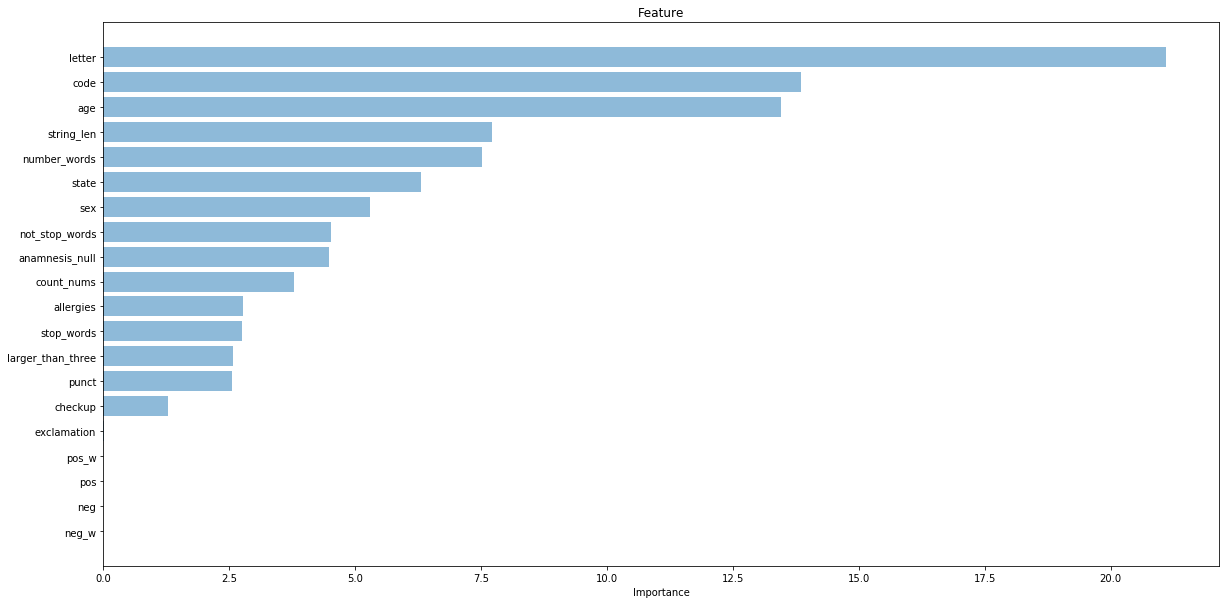

In [68]:
draw_importance(X_train.columns, model.feature_importances_, save_path=None)

In [38]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = get_stack_score(X_test)
# sdf.head()

## LIGHTGBM

In [39]:
# import lightgbm as lgb

In [40]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [41]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': ['binary_logloss', 'auc'],
#     'num_leaves': 31,
#     'learning_rate': 0.02,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0,
#     'depth': 8,
#     'subsample': 0.7
# }

# model = lgb.train(params,
#                   lgb_train,
#                   num_boost_round=50,
#                   valid_sets=lgb_eval,
#                   early_stopping_rounds=50)

In [42]:
# model.feature_importance()

In [43]:
# def draw_importance(columns, importances, top_k=20, save_path=None):
#     order = np.argsort(importances)[-top_k:]
    
#     objects = columns[order]
#     y_pos = np.arange(len(objects))
#     performance = np.array(importances)[order]

#     plt.figure(figsize=(20, 10))
#     plt.barh(y_pos, performance, align='center', alpha=0.5)
#     plt.yticks(y_pos, objects)
#     plt.xlabel('Importance')
#     plt.title('Feature')

#     if save_path:
#         plt.savefig(save_path)
#     plt.show()

In [44]:
# draw_importance(X_train.columns, model.feature_importance(), save_path=None)

In [45]:
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [46]:
# from sklearn.linear_model import LogisticRegression

## Submission

In [64]:
sdf = pd.DataFrame(tdf.index, columns=['ID'])
sdf['proba'] = model.predict_proba(X_test)[:, 1]
sdf.head()

,ID,proba
0,0,0.599900
1,1,0.563002
2,2,0.380643
3,3,0.816197
4,4,0.260827


In [65]:
sdf.to_csv(SUBMISSION_PATH, index=False)

## BT_ITER

In [49]:
# N_ITERS = 2

In [50]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [51]:
# np.where((y_prob1 >= .95) | (y_prob1 <= .05))[0].shape

In [52]:
# y_prob1 = model.predict_proba(X_test)[:, 1]

In [53]:
# np.where(y_prob1 <= .5)[0].shape

In [54]:
# np.where(y_prob1 >= .95)[0].shape

In [55]:
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1
# vtdf = vtdf.loc[t0i | t1i]
# vtdf.head()

In [56]:
# confusion_matrix(y_val, model.predict(X_val))

In [57]:
# (y_val == 0).sum() / len(y_val)

In [58]:
# vdf = df.copy()

# # TT split
# preprocess = FFTransformer()
# X, y = preprocess.fit_transform(vdf)
# cat_features = np.where(X.dtypes != np.float)[0]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_test = preprocess.transform(tdf)

# # Train
# model = cb.CatBoostClassifier(depth=8, eval_metric='AUC', 
#                               iterations=1000)
# model.fit(X_train, y_train, cat_features=cat_features, 
#           use_best_model=True, eval_set=(X_val, y_val), 
#           plot=False);

# # BT
# y_prob1 = model.predict_proba(X_test)[:, 1]
# t0i = np.where(y_prob1 <= .05)[0]
# t1i = np.where(y_prob1 >= .95)[0]
# vtdf = tdf.copy()
# vtdf['revisit'] = np.zeros(len(vtdf)).astype(int)
# vtdf.loc[t1i, 'revisit'] = 1


# # Submission
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = y_prob1
# sdf.to_csv(SUBMISSION_PATH, index=False)

In [59]:
# s1 = pd.read_csv('submission.csv').proba
# s2 = pd.read_csv('10_8_stack080_020.csv').proba

In [60]:
# from scipy.stats import pearsonr

In [61]:
# pearsonr(s1, s2)

In [62]:
# sdf.head()

In [63]:
# sdf = pd.DataFrame(tdf.index, columns=['ID'])
# sdf['proba'] = (s1 + s2) / 2
# sdf.to_csv(SUBMISSION_PATH, index=False)